In [1]:
pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

from feature_engine.imputation import MeanMedianImputer

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


数据基本情况检查

In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
pd.DataFrame(data = [train.isna().sum()/train.shape[0]*100, test.isna().sum()/test.shape[0]*100], 
             index=["Train Null (%)", "Test Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Train Null (%),Test Null (%)
Id,0.000000,0.000000
MSSubClass,0.000000,0.000000
MSZoning,0.000000,0.274160
LotFrontage,17.739726,15.558602
LotArea,0.000000,0.000000
Street,0.000000,0.000000
Alley,93.767123,92.666210
LotShape,0.000000,0.000000
LandContour,0.000000,0.000000
Utilities,0.000000,0.137080


In [5]:
train_data = train.drop(['Alley','PoolQC','Fence','MiscFeature'],axis = 1)
test_data = test.drop(['Alley','PoolQC','Fence','MiscFeature'],axis = 1)
### 'FirePlaceQ'???要删吗？？

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


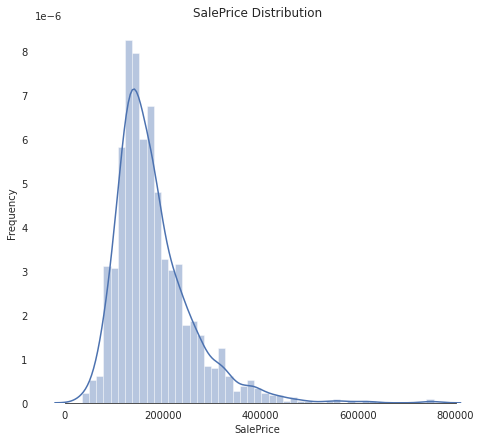

In [6]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice Distribution")
sns.despine(trim=True, left=True)
plt.show()

In [7]:
# 斜度 和 曲度
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


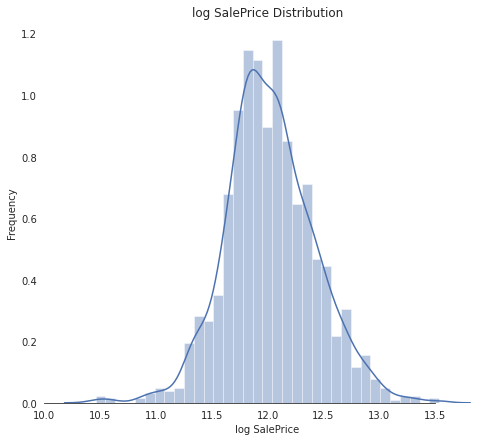

In [8]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(np.log(train['SalePrice']), color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="log SalePrice")
ax.set(title="log SalePrice Distribution")
sns.despine(trim=True, left=True)
plt.show()

In [9]:
# 斜度 和 曲度
print("Skewness: %f" % np.log(train['SalePrice']).skew())
print("Kurtosis: %f" % np.log(train['SalePrice']).kurt())

Skewness: 0.121335
Kurtosis: 0.809532


**我们可以考虑对lnY回归？？？**

In [10]:
# Finding numeric features
# 好像这样分出来的也不全是数值型的？？？
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = []
cat = []
for i in train_data.columns:
    if (train_data[i].dtype in numeric_dtypes)&(i != 'SalePrice'):
            num.append(i)  
    elif i != 'SalePrice': #elif train_data[i].dtype=='object'
            cat.append(i)
     

In [11]:
## Dummy variable (one-hot) 
train_data.insert(train_data.shape[1],'lable',np.ones(train_data.shape[0]))
test_data.insert(test_data.shape[1],'lable',np.zeros(test_data.shape[0]))
data = pd.concat([train_data,test_data],axis = 0)
data = data.join(pd.get_dummies(data[cat]), how = 'outer')
data.drop(cat,axis = 1, inplace = True)
train_data = data[data['lable']==1]
test_data = data[data['lable']==0]

缺失值补齐：https://www.kaggle.com/code/dansbecker/handling-missing-values

1. 缺失值占比很少很少的用平均值或者中位数？？？0%~10% sklearn.impute.SimpleImputer

2. 缺失值稍微大的用????  10%以上的50%以下的

50%以上的扔了吧

In [12]:
## 先全部用中位数补齐了
median_imputer = MeanMedianImputer(imputation_method="median")
x_train = train_data.drop('SalePrice',axis = 1)
y_train = train_data['SalePrice']
x_train = median_imputer.fit_transform(x_train)

**各变量分布情况**

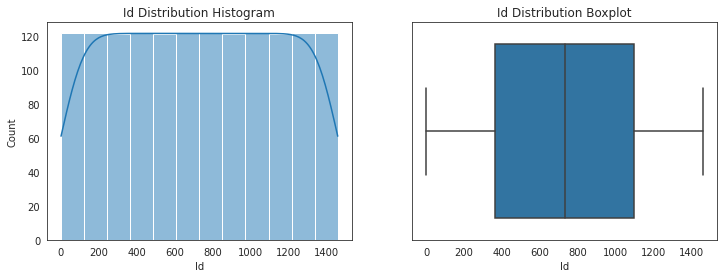

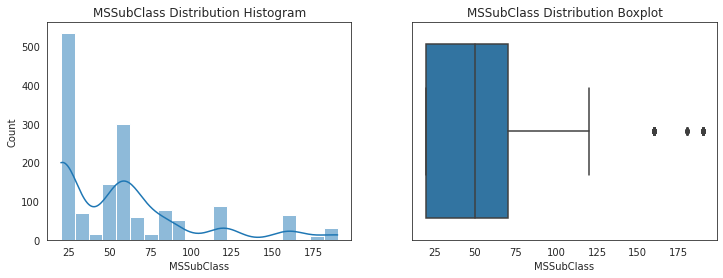

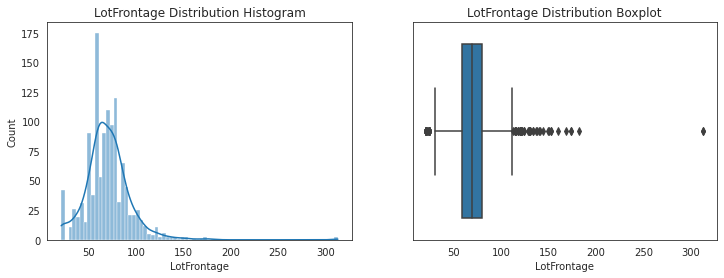

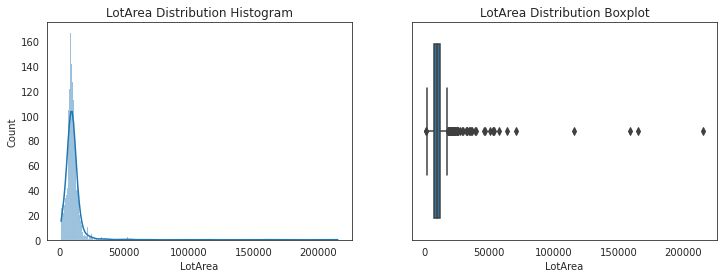

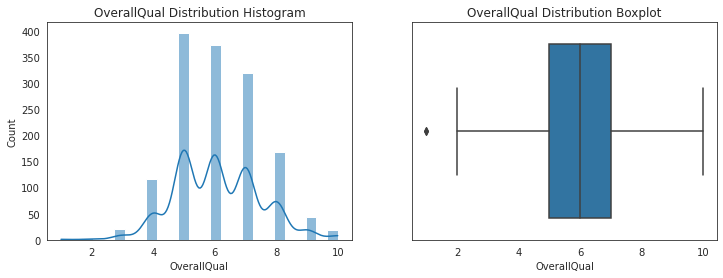

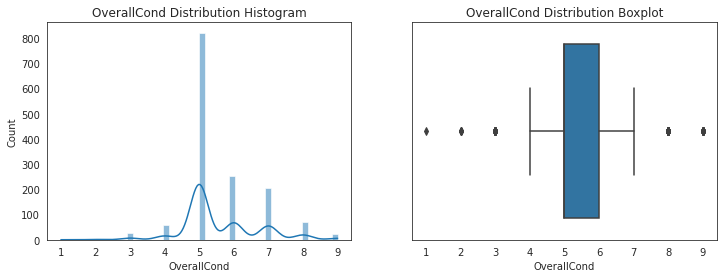

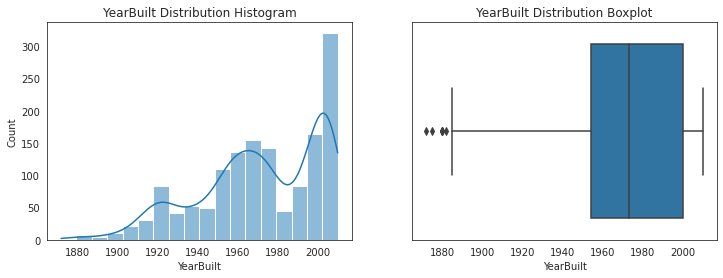

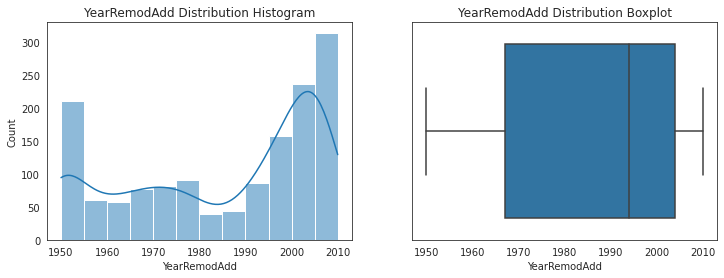

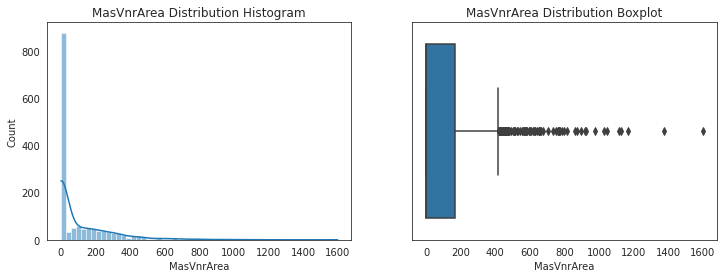

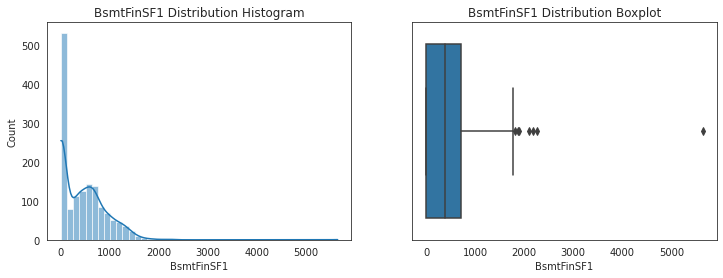

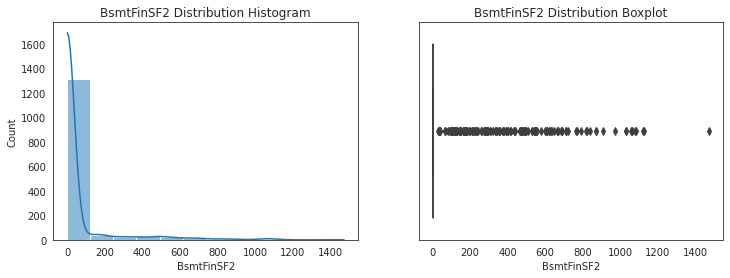

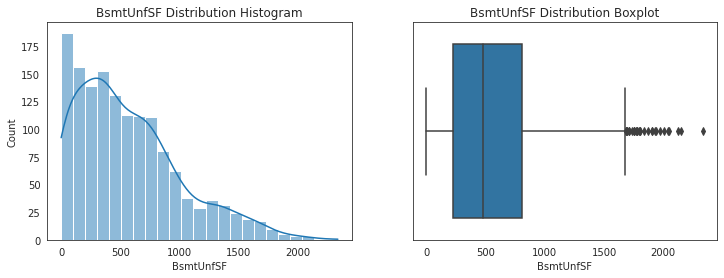

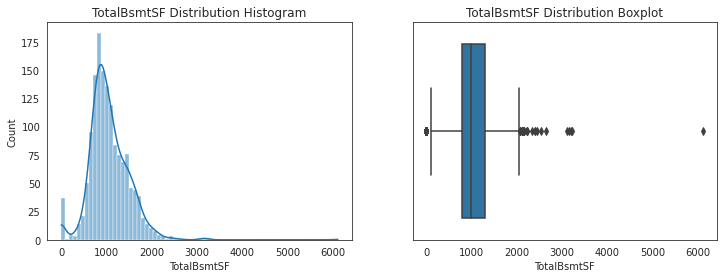

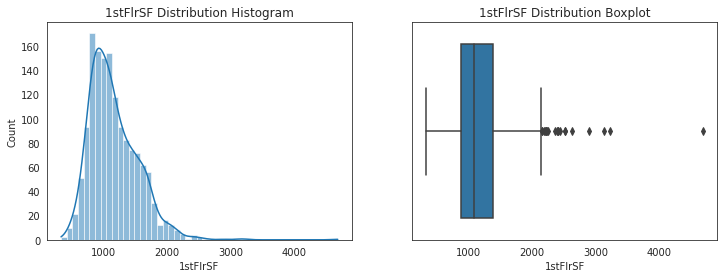

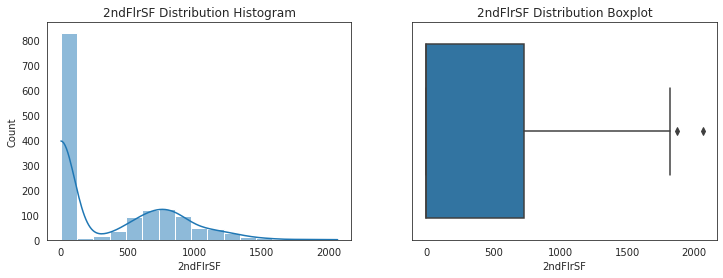

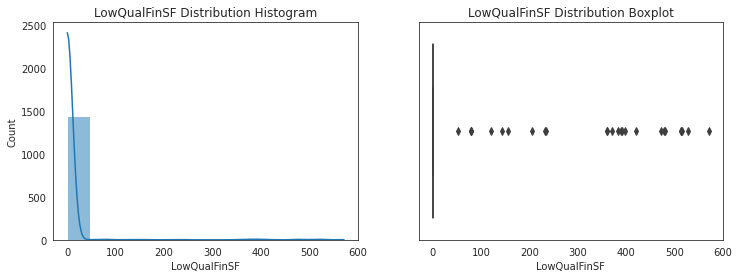

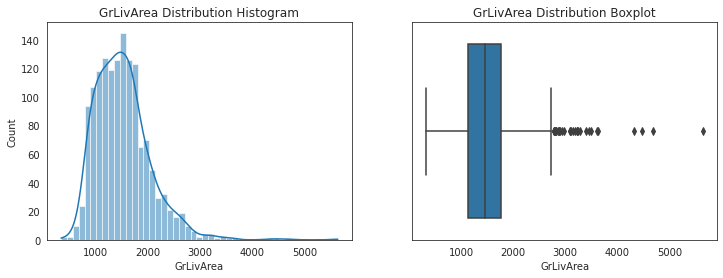

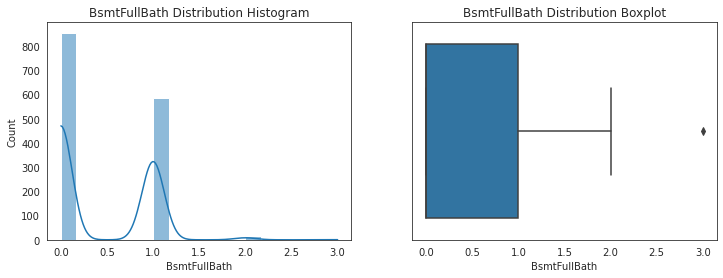

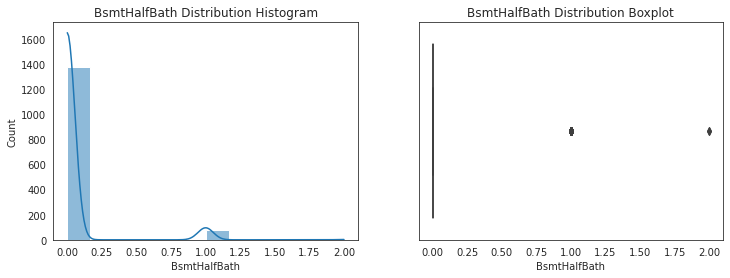

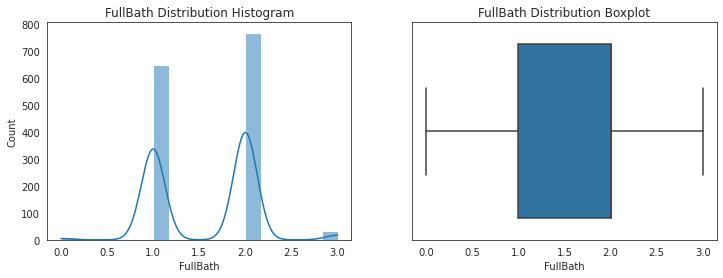

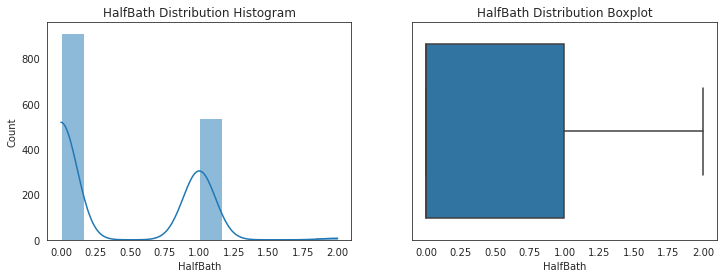

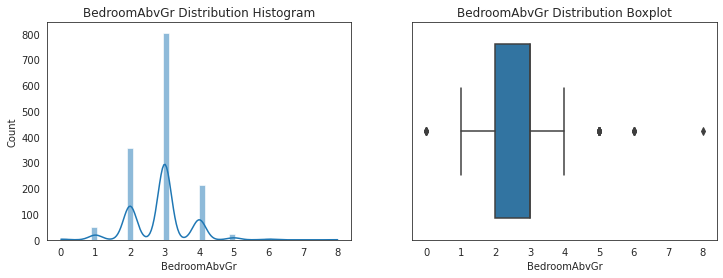

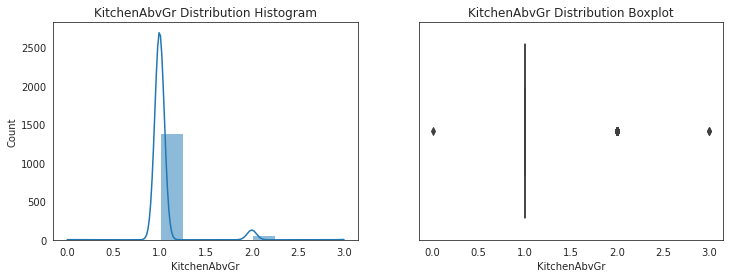

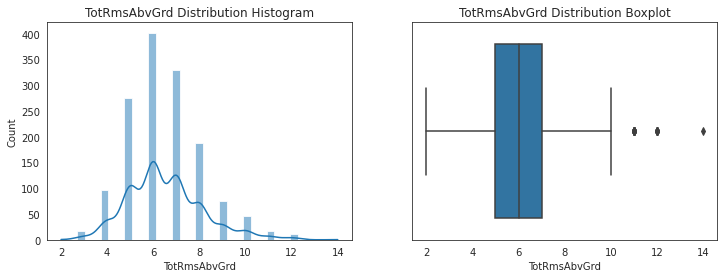

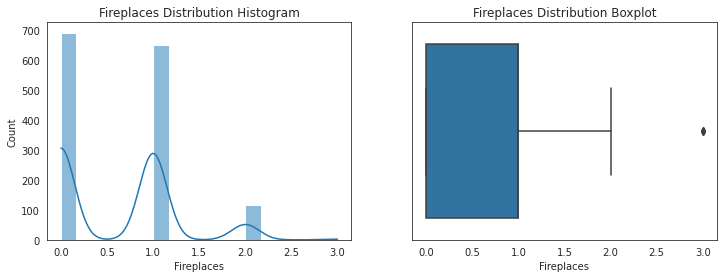

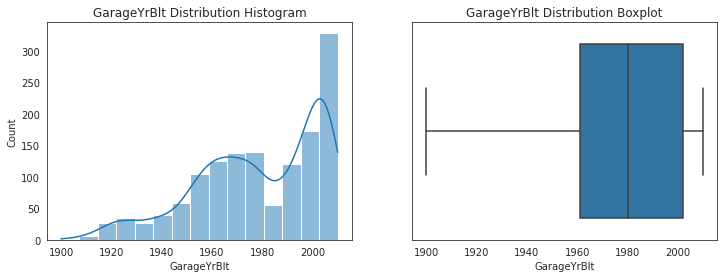

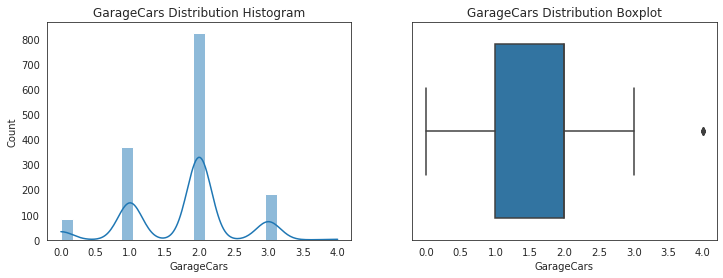

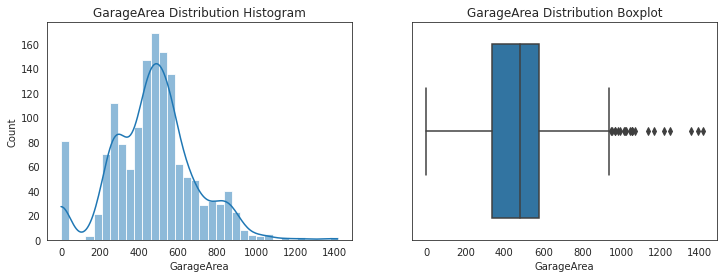

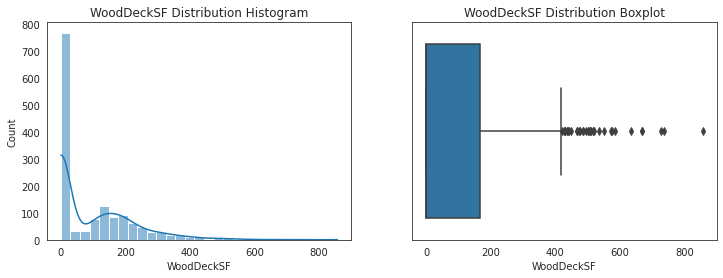

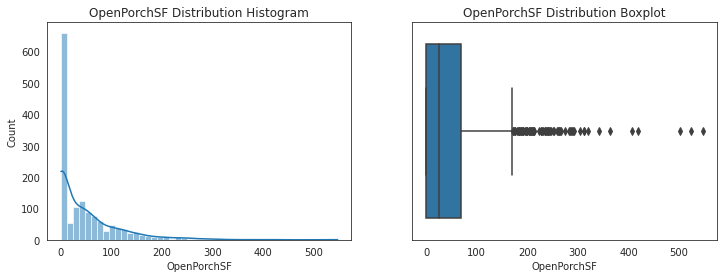

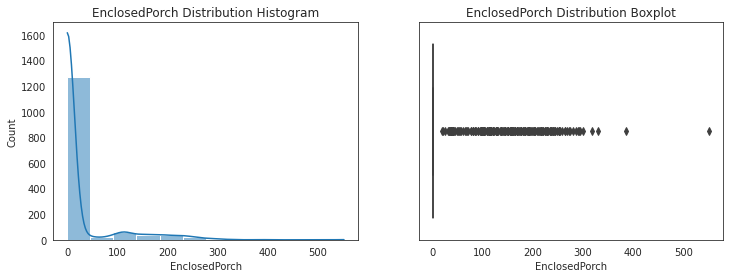

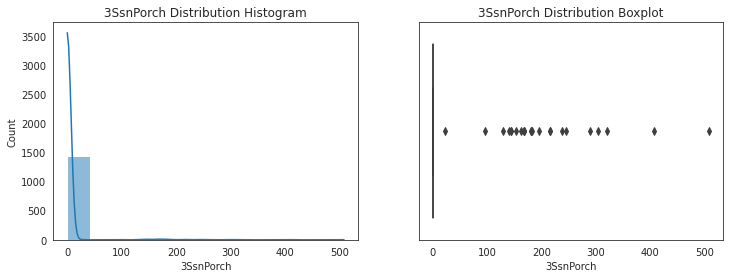

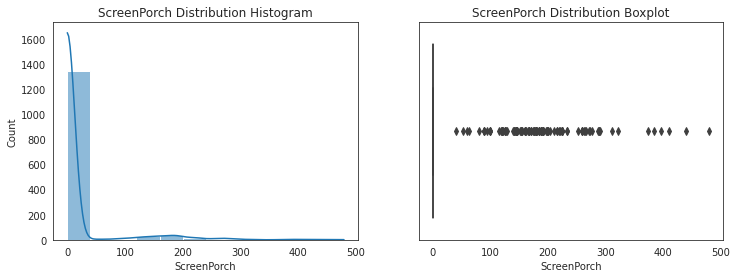

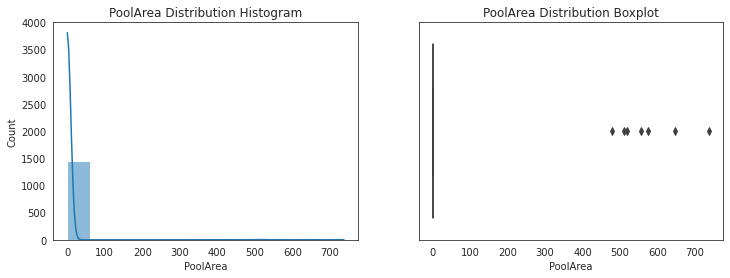

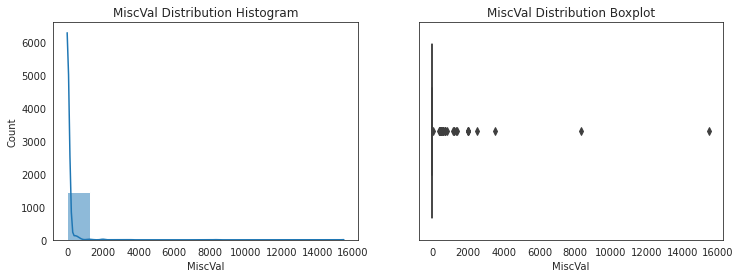

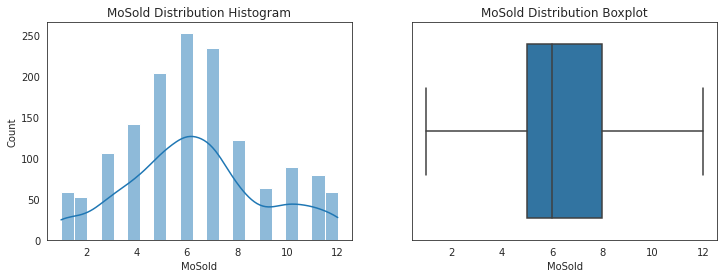

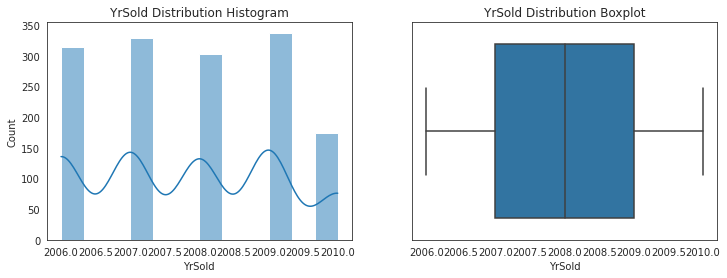

In [13]:
def num_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=var, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=var, ax=ax[1])
    ax[0].set_title(f"{var} Distribution Histogram")
    ax[1].set_title(f"{var} Distribution Boxplot")

    plt.show()
for var in num:
    num_dist(train, var)

In [14]:
def cat_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    train_data[var].value_counts().plot(kind="pie", explode=[0.05 for x in data[var].dropna().unique()], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(f"{var} Pie Chart")
    ax[0].set_ylabel('')

    count = sns.countplot(x=var, data=train_data, ax=ax[1])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{var} Bar Chart")
    plt.show()
'''
for c in cat:
    cat_dist(train,c)
'''

'\nfor c in cat:\n    cat_dist(train,c)\n'

**粗略回归**

In [15]:
# Standardize numerical features
stdSc = StandardScaler()
x_train.loc[:, num] = stdSc.fit_transform(x_train.loc[:, num])

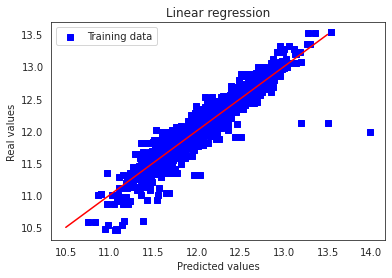

In [16]:
# Linear Regression
lr = LinearRegression()
lr.fit(x_train, np.log(y_train))

# Look at predictions on training and validation set
y_train_pred = lr.predict(x_train)

# Plot predictions
plt.scatter(y_train_pred, np.log(y_train), c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [17]:
#finally succeed
#change1